In [107]:
import os
import keras
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

REMOVE_DUPLICATE_EEG_IDS = True # if True, each row in training corresponds to a unique eeg_id
AVERAGE_TARGETS_OVER_EEG = True
MAX_ROWS = None # use only MAX_ROWS rows of train.csv, set to None to use all rows
USE_CACHE = True # stores all accessed eeg and spectrogram files in memory

DATA_DIR = 'data' # /kaggle/input/hms-harmful-brain-activity-classification/

In [108]:
train_csv = pd.read_csv(f'{DATA_DIR}/train.csv', dtype={'eeg_label_offset_seconds': 'int', 'spectrogram_label_offset_seconds': 'int'})
TARGETS = train_csv.columns[-6:]

def actual_median(s):
    return s.iloc[(s - s.median()).abs().argsort().iloc[0]]

if REMOVE_DUPLICATE_EEG_IDS:
    df_unique_eeg = train_csv.groupby('eeg_id')[['eeg_label_offset_seconds']].agg(actual_median)
    train_df = pd.merge(df_unique_eeg, train_csv, on=['eeg_id', 'eeg_label_offset_seconds'], how='left')
    
    if AVERAGE_TARGETS_OVER_EEG:
        y = train_csv.groupby('eeg_id')[TARGETS].agg('sum')
        y = y.div(y.sum(axis=1), axis=0)
        train_df[TARGETS] = y[TARGETS].values
else:
    train_df = train_csv

train_df = train_df[:MAX_ROWS]

train_df

,eeg_id,eeg_label_offset_seconds,eeg_sub_id,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,6,1,789577333,1,6,3640441665,20654,Other,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,18,5,1552638400,5,18,1179854295,20230,LPD,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,0,0,14960202,12,1008,3254468733,5955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,0,0,618728447,4,908,2898467035,38549,GPD,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,0,0,52296320,0,0,3255875127,40955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,0,0,1188113564,0,0,447244163,16610,GRDA,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17085,4293843368,0,0,1549502620,0,0,1618953053,15065,GRDA,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17086,4294455489,0,0,2105480289,0,0,469526364,56,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
17087,4294858825,6,2,657299228,2,6,3251917981,4312,Other,0.0,0.000000,0.00,0.000000,0.066667,0.933333


In [109]:
from functools import cache


# @cache
# def read_eeg_train(eeg_id):
#     return pd.read_parquet(f'{DATA_DIR}/train_eegs/{eeg_id}.parquet')

# def read_eeg_test(eeg_id):
#     return pd.read_parquet(f'{DATA_DIR}/test_eegs/{eeg_id}.parquet')

# def eeg_window(row, train=True):
#     eeg_data = (read_eeg_train if train else read_eeg_test)(row.eeg_id)
#     if train:
#         eeg_offset = int(row.eeg_label_offset_seconds)
#         eeg_data = eeg_data.iloc[(200 * eeg_offset):(200 * (eeg_offset + 50))]
#     return eeg_data


spg_cache = {}
spg_cache_file = f'{DATA_DIR}/cache/spg_cache.npy'
if os.path.exists(spg_cache_file):
    spg_cache = np.load(spg_cache_file, allow_pickle=True).item()

def read_spg(spg_id, train=True):
    if spg_id in spg_cache:
        return spg_cache[spg_id]
    else:
        if train:
            spg = pd.read_parquet(f'{DATA_DIR}/train_spectrograms/{spg_id}.parquet')
            spg_cache[spg_id] = spg
        else:
            spg = pd.read_parquet(f'{DATA_DIR}/test_spectrograms/{spg_id}.parquet')
        return spg

def spg_window(row, train=True):
    spg_data = read_spg(row.spectrogram_id, train)
    if train:
        spg_offset = int(row.spectrogram_label_offset_seconds)
        spg_data = spg_data.loc[(spg_data.time >= spg_offset) & (spg_data.time < spg_offset + 600)]
        spg_data = spg_data.drop(columns=['time'])
    return spg_data

# spg_window(train_df.iloc[133])
# read_spg(train_df.iloc[14583].spectrogram_id).isna().any()
# train_df.iloc[133]

In [110]:
import librosa

IMAGE_HEIGHT = 100  # fixed
IMAGE_WIDTH = 200  # no more than (10000 / HOP_LENGTH)

EEG_FREQ = 200
HOP_LENGTH = 50
SPG_FREQ = EEG_FREQ // HOP_LENGTH

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

def eeg_to_spg(eeg, n_mels=IMAGE_HEIGHT, display=False):
    hop_length = HOP_LENGTH  # window hop/shift step size: 50 / 200 = 0.25s
    win_length = 2 * hop_length  # window size: 0.5s
    n_windows = len(eeg) // hop_length  # number of windows

    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((n_mels, n_windows, 4), dtype='float32')
    
    for i in range(4):
        COLS = FEATS[i]
        for j in range(4):  # 5 columns
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[j]].values - eeg[COLS[j + 1]].values

            # FILL NANS
            x = np.nan_to_num(x, nan=0.0)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=hop_length,
                  n_fft=1024, n_mels=n_mels, fmin=0, fmax=20, win_length=win_length)
            
            # LOG TRANSFORM
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)

            img[:, :, i] += 0.25 * mel_spec_db[:, :n_windows]
            
        if display:
            plt.subplot(2, 2, i + 1)
            plt.imshow(img[:, :, i], aspect='auto', origin='lower')
    
    return img


eeg_spg_cache = {}
eeg_spg_cache_file = f'{DATA_DIR}/cache/eeg_spg_cache.npy'
if os.path.exists(eeg_spg_cache_file):
    eeg_spg_cache = np.load(eeg_spg_cache_file, allow_pickle=True).item()

def eeg_id_to_spg(eeg_id, train=True):
    if eeg_id in eeg_spg_cache:
        return eeg_spg_cache[eeg_id]
    else:
        if train:
            eeg_spg = eeg_to_spg(pd.read_parquet(f'{DATA_DIR}/train_eegs/{eeg_id}.parquet'))
            eeg_spg_cache[eeg_id] = eeg_spg
        else:
            eeg_spg = eeg_to_spg(pd.read_parquet(f'{DATA_DIR}/test_eegs/{eeg_id}.parquet'))
        return eeg_spg


def eeg_spg_window(row, train=True):
    eeg_spg_array = eeg_id_to_spg(row.eeg_id, train)
    if train:
        eeg_offset = int(row.eeg_label_offset_seconds)
        eeg_spg_array = eeg_spg_array[:, (SPG_FREQ * eeg_offset):(SPG_FREQ * (eeg_offset + 50))]
    return eeg_spg_array


# spg_from_eeg(eeg_window(train_df.iloc[0]), display=True).shape
eeg_spg_window(train_df.iloc[0]).shape

(100, 200, 4)

In [111]:
import albumentations as albu

class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, batch_size=32, shuffle=False, augment=False, test_mode=False, **kwargs):
        super().__init__(**kwargs)
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.test_mode = test_mode
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        """Denotes the number of batches per epoch"""
        m, r = divmod(len(self.data), self.batch_size)
        return m + (1 if r > 0 else 0)

    def __getitem__(self, i):
        """Generate one batch of data"""
        indices = self.indices[(i * self.batch_size):((i + 1) * self.batch_size)]
        X, y = self.__data_generation(indices)
        if self.augment:
            X = self.__augment_batch(X) 
        return X, y
    
    def __data_generation(self, indices):
        spg_window_left = 150 - IMAGE_WIDTH // 2
        spg_window_right = 150 + IMAGE_WIDTH // 2
        eeg_window_left = 50 * EEG_FREQ // HOP_LENGTH // 2 - IMAGE_WIDTH // 2
        eeg_window_right = 50 * EEG_FREQ // HOP_LENGTH // 2 + IMAGE_WIDTH // 2
        X = np.zeros((len(indices), IMAGE_HEIGHT, IMAGE_WIDTH, 8), dtype='float32')
        y = np.zeros((len(indices), 6), dtype='float32')

        for i_batch, i_row in enumerate(indices):
            row = self.data.iloc[i_row]

            spg = spg_window(row, train=not self.test_mode).values.T

            for j in range(4):
                img = spg[(j * 100):((j + 1) * 100), spg_window_left:spg_window_right]
                
                img = np.nan_to_num(img, nan=0.0)
                
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)
                img = img - img.mean()
                img = img / (img.std() + 1e-6)
                
                X[i_batch, :, :, j] = img[:, :]

            img = eeg_spg_window(row)
            img = img - img.mean()
            img = img / (img.std() + 1e-6)
            X[i_batch, :, :, 4:] = img[:, eeg_window_left:eeg_window_right]

            if not self.test_mode:
                y[i_batch, :] = row[TARGETS]

        return X, y
    
    def __random_transform(self, img):
        composition = albu.Compose([
            # albu.XYMasking(num_masks_x=[1, 5], num_masks_y=[1, 5], mask_x_length=(5, 10), mask_y_length=(1, 2), p=0.5),
            albu.augmentations.crops.transforms.RandomResizedCrop(IMAGE_HEIGHT, IMAGE_WIDTH, scale=(0.9, 1.0), ratio=(0.9, 1.1))
            # albu.augmentations.geometric.resize.RandomScale(scale_limit=0.5, always_apply=True),
            # albu.augmentations.crops.CenterCrop(IMAGE_HEIGHT, IMAGE_WIDTH, always_apply=True)
            # albu.HorizontalFlip(p=0.5),
            # albu.GaussNoise(var_limit=(0, 0.5), p=0.5),
            # albu.RandomBrightnessContrast(),
            # albu.Sharpen(),
            #albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
        ])
        return composition(image=img)['image']
            
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        return img_batch

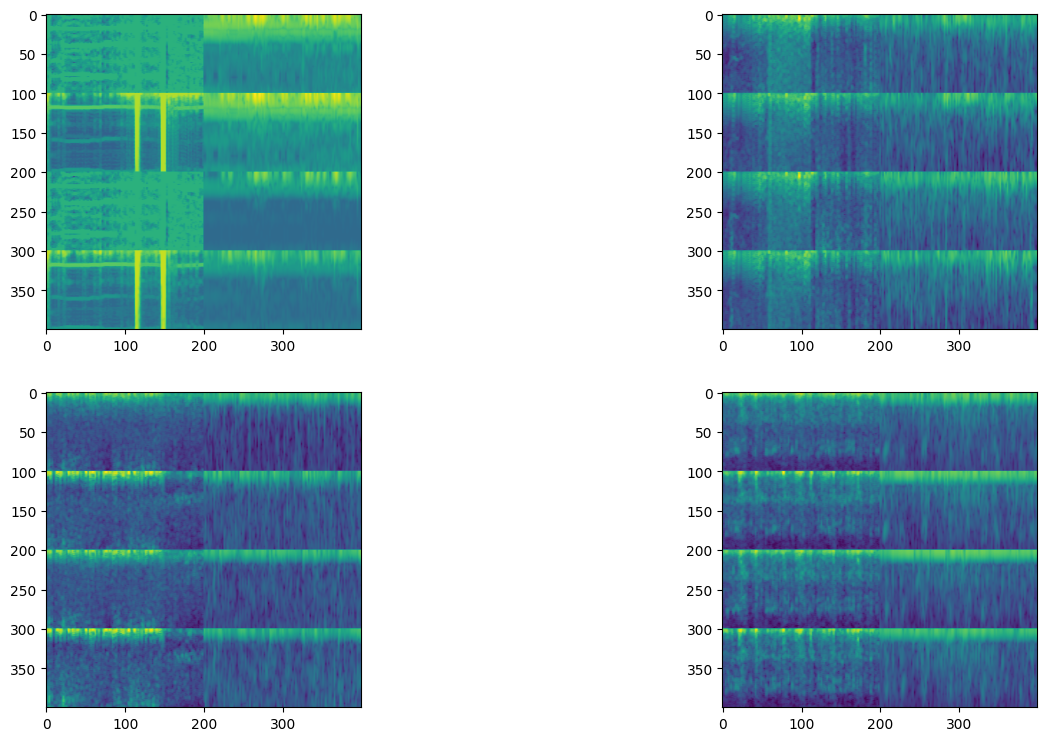

In [112]:
gen = DataGenerator(train_df, shuffle=True, augment=True)

ROWS = 2
COLS = 2
BATCHES = 1

for i, (X, y) in enumerate(gen):
    plt.figure(figsize=(16, 9))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j * COLS + k + 1)
            t = y[j * COLS + k]
            img_spg = np.concatenate([X[j * COLS + k, :, :, a] for a in range(4)], axis=0)
            img_eeg = np.concatenate([X[j * COLS + k, :, :, a] for a in range(4, 8)], axis=0)
            img = np.concatenate([img_spg, img_eeg], axis=1)
            plt.imshow(img)
    plt.show()
    if i == BATCHES - 1:
        break

In [113]:
def build_model():
    base_model = keras.applications.efficientnet.EfficientNetB0(include_top=False, weights='imagenet', input_shape=None)

    inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 8))

    x1 = keras.layers.Concatenate(axis=1)([inputs[:, :, :, i:(i + 1)] for i in range(4)])
    x2 = keras.layers.Concatenate(axis=1)([inputs[:, :, :, i:(i + 1)] for i in range(4, 8)])
    x = keras.layers.Concatenate(axis=2)([x1, x2])
    x = keras.layers.Concatenate(axis=3)([x, x, x])

    x = base_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(6, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=x)
    model.compile(loss=keras.losses.KLDivergence(), optimizer=keras.optimizers.Adam(learning_rate=1e-3))

    return model

In [114]:
from sklearn.model_selection import GroupKFold

N_EPOCHS = 4

def lr_scheduler(epoch, lr):
    return lr if epoch < 2 else lr * 0.1
callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

out_of_folds_predicts = []
out_of_folds_labels = []

group_k_fold = GroupKFold(n_splits=5)
for i, (train_indices, valid_indices) in enumerate(group_k_fold.split(train_df, groups=train_df.patient_id)):
    print(f'{"_" * 30} Fold {i} {"_" * 30}')

    train_data_gen = DataGenerator(train_df.iloc[train_indices], shuffle=True, augment=True)
    valid_data_gen = DataGenerator(train_df.iloc[valid_indices], shuffle=False, batch_size=64)

    model = build_model()
    model.fit(train_data_gen, validation_data=valid_data_gen, epochs=N_EPOCHS, callbacks=[callback], verbose=1)
    model.save_weights(f'model_en0_v2_f{i}.weights.h5')

    out_of_folds_predicts.append(model.predict(valid_data_gen))
    out_of_folds_labels.append(train_df.iloc[valid_indices][TARGETS].values)

out_of_folds_predicts = np.concatenate(out_of_folds_predicts)
out_of_folds_labels = np.concatenate(out_of_folds_labels)

______________________________ Fold 0 ______________________________
Epoch 1/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 108s 150ms/step - loss: 0.7916 - val_loss: 1.7923 - learning_rate: 0.0010
Epoch 2/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - loss: 0.5200 - val_loss: 1.9831 - learning_rate: 0.0010
Epoch 3/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - loss: 0.4031 - val_loss: 1.1612 - learning_rate: 1.0000e-04
Epoch 4/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - loss: 0.3223 - val_loss: 1.1593 - learning_rate: 1.0000e-05
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step
______________________________ Fold 1 ______________________________
Epoch 1/4
 61/428 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - loss: 1.0199

In [ ]:
from kaggle_kl_div import score

out_of_folds_predicts_df = pd.DataFrame(out_of_folds_predicts.copy())
out_of_folds_predicts_df['id'] = np.arange(len(out_of_folds_predicts))

out_of_folds_labels_df = pd.DataFrame(out_of_folds_labels.copy())
out_of_folds_labels_df['id'] = np.arange(len(out_of_folds_labels))

score(solution=out_of_folds_labels_df, submission=out_of_folds_predicts_df, row_id_column_name='id')


0.5985598798264276

| CV | N_EPOCHS | augment | HOP_LENGTH | IMAGE_WIDTH |
|---|---|---|---|---|
| 0.5878570498295667 | 4 | False | 50 | 200 |
| 0.6043616237737167 | 4 | XYMasking(num_masks_x=1, num_masks_y=1, mask_x_length=(40, 20), mask_y_length=(20, 10), p=1) | 50 | 200 |
| 0.5985598798264276 | 4 | XYMasking(num_masks_x=[1, 5], num_masks_y=[1, 10], mask_x_length=(5, 10), mask_y_length=(1, 2), p=0.5) | 50 | 200 |
| 0.588225632626801 | 4 | XYMasking(num_masks_x=[1, 5], num_masks_y=[1, 5], mask_x_length=(5, 10), mask_y_length=(2, 5), p=0.5) | 50 | 200 |
| 0.5873564400750843 | 4 | XYMasking(num_masks_x=[1, 5], num_masks_y=[1, 5], mask_x_length=(2, 4), mask_y_length=(1, 2), p=0.5) | 50 | 200 |
| 0.587237356938107 | 4 | XYMasking(num_masks_x=[1, 2], num_masks_y=[1, 2], mask_x_length=(10, 20), mask_y_length=(5, 10), p=1) | 50 | 200 |
| 0.5856693916188898 | 4 | XYMasking(num_masks_x=[1, 10], num_masks_y=[1, 5], mask_x_length=(5, 10), mask_y_length=(1, 2), p=0.5) | 50 | 200 |
| 0.5820978655018046 | 4 | XYMasking(num_masks_x=[1, 2], num_masks_y=[1, 2], mask_x_length=(10, 20), mask_y_length=(5, 10), p=0.5) | 50 | 200 |
| 0.5816122349523126 | 4 | XYMasking(num_masks_x=[1, 2], num_masks_y=[1, 5], mask_x_length=(5, 10), mask_y_length=(1, 2), p=0.5) | 50 | 200 |
| 0.5790920109940367 | 4 | XYMasking(num_masks_x=[1, 5], num_masks_y=[1, 5], mask_x_length=(5, 10), mask_y_length=(1, 2), p=0.5) | 50 | 200 |


In [ ]:
# spg_cache_file = f'{DATA_DIR}/cache/spg_cache.npy'
# eeg_spg_cache_file = f'{DATA_DIR}/cache/eeg_spg_cache.npy'
# np.save(spg_cache_file, spg_cache)
# np.save(eeg_spg_cache_file, eeg_spg_cache)